Mean Profit Ratio: -0.0011686895246753246
Median Profit Ratio: nan
Standard Deviation of Profit Ratio: 0.0026812432006972373


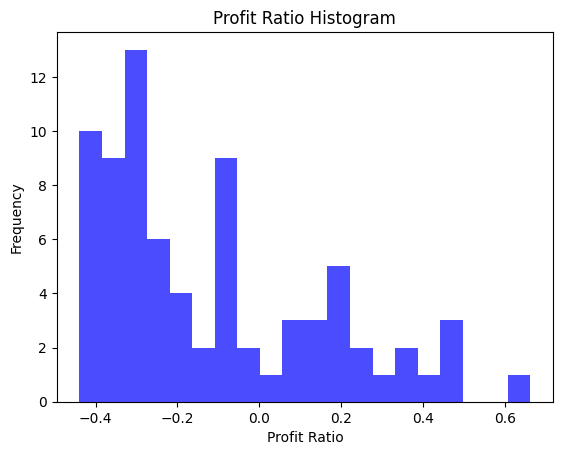

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your JSON file
json_file_path = '/allah/freqtrade/json_dict/2023-09-06_15-50-30_MacdStrategyLong.json'

# Read the JSON file into a pandas DataFrame
df = pd.read_json(json_file_path)

# Calculate statistics using NumPy
mean_profit_ratio = np.mean(df['profit_ratio'])
median_profit_ratio = np.median(df['profit_ratio'])
std_deviation_profit_ratio = np.std(df['profit_ratio'])
df['profit_ratio'] = df['profit_ratio'] * 100

# Print statistics
print(f"Mean Profit Ratio: {mean_profit_ratio}")
print(f"Median Profit Ratio: {median_profit_ratio}")
print(f"Standard Deviation of Profit Ratio: {std_deviation_profit_ratio}")

# Create a histogram to visualize profit ratios
plt.hist(df['profit_ratio'], bins=20, color='blue', alpha=0.7)
plt.title('Profit Ratio Histogram')
plt.xlabel('Profit Ratio')
plt.ylabel('Frequency')
plt.show()

# You can perform more advanced analyses and visualizations based on your specific needs.


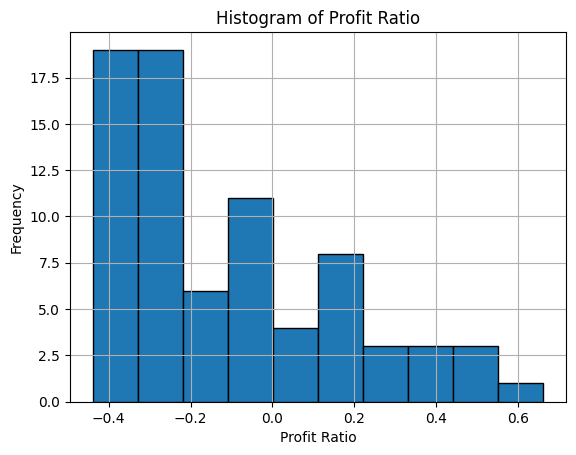

In [26]:
df[df['trade'] == 1]
plt.hist(df['profit_ratio'], bins=10, edgecolor='k')
plt.xlabel('Profit Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Profit Ratio')
plt.grid(True)
plt.show()

In [31]:
df

,date,open,high,low,close,volume,macd,macdsignal,macdhist,trade,is_short,profit_ratio,label
0,2023-09-03 22:30:00,1635.54,1636.38,1635.54,1636.13,582.147,NaN,NaN,NaN,NaN,NaN,NaN,
1,2023-09-03 22:33:00,1636.12,1636.13,1635.24,1635.24,855.884,NaN,NaN,NaN,NaN,NaN,NaN,
2,2023-09-03 22:36:00,1635.25,1635.25,1632.21,1633.87,6105.703,NaN,NaN,NaN,NaN,NaN,NaN,
3,2023-09-03 22:39:00,1633.87,1635.52,1633.87,1634.36,1519.262,NaN,NaN,NaN,NaN,NaN,NaN,
4,2023-09-03 22:42:00,1634.36,1634.58,1634.06,1634.15,547.550,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,2023-09-06 06:24:00,1630.49,1630.79,1630.01,1630.18,2773.990,-0.087311,-0.495457,0.408146,NaN,NaN,NaN,
1119,2023-09-06 06:27:00,1630.19,1630.19,1629.36,1629.37,782.363,-0.049930,-0.406352,0.356422,NaN,NaN,NaN,
1120,2023-09-06 06:30:00,1629.36,1630.06,1629.35,1630.06,1512.709,0.034969,-0.318088,0.353056,NaN,NaN,NaN,
1121,2023-09-06 06:33:00,1630.06,1630.57,1629.72,1629.83,1464.030,0.082739,-0.237922,0.320661,NaN,NaN,NaN,
